In [1]:
from threading import active_count
import kmapper as km
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding
from gtda.homology import VietorisRipsPersistence, WeakAlphaPersistence, EuclideanCechPersistence, SparseRipsPersistence
from gtda.diagrams import PersistenceLandscape
from kmapper import Cover
from numpy.ma.core import equal
from scipy.stats import mode
from sklearn import ensemble, cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors

def load_and_prep_data():
    columns_to_keep = [
        ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
        ' Flow Duration', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std',
        ' Flow IAT Max', ' Flow IAT Min', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
        ' Fwd IAT Min', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
        'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean',
        ' Idle Std', ' Idle Max', ' Idle Min', ' Label'
    ]
    df = pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
                     encoding='ISO-8859-1', usecols=columns_to_keep, low_memory=False)
    df.columns = df.columns.str.strip()

    highest_non_inf = df.loc[df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
    df.replace(np.inf, highest_non_inf, inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df = df.dropna()

    df["Source IP"] = df["Source IP"].apply(lambda x: float(str(x).replace(".", "")))
    df["Destination IP"] = df["Destination IP"].apply(lambda x: float(str(x).replace(".", "")))
    df['Flow Duration'] = df['Flow Duration'].clip(lower=1e-6)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)

    label_map = {"BENIGN": 0, "Web Attack ï¿½ Brute Force": 11, "Web Attack ï¿½ XSS": 12, "Web Attack ï¿½ Sql Injection": 13}
    df["Label"] = df["Label"].map(label_map)

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    return df

df = load_and_prep_data()

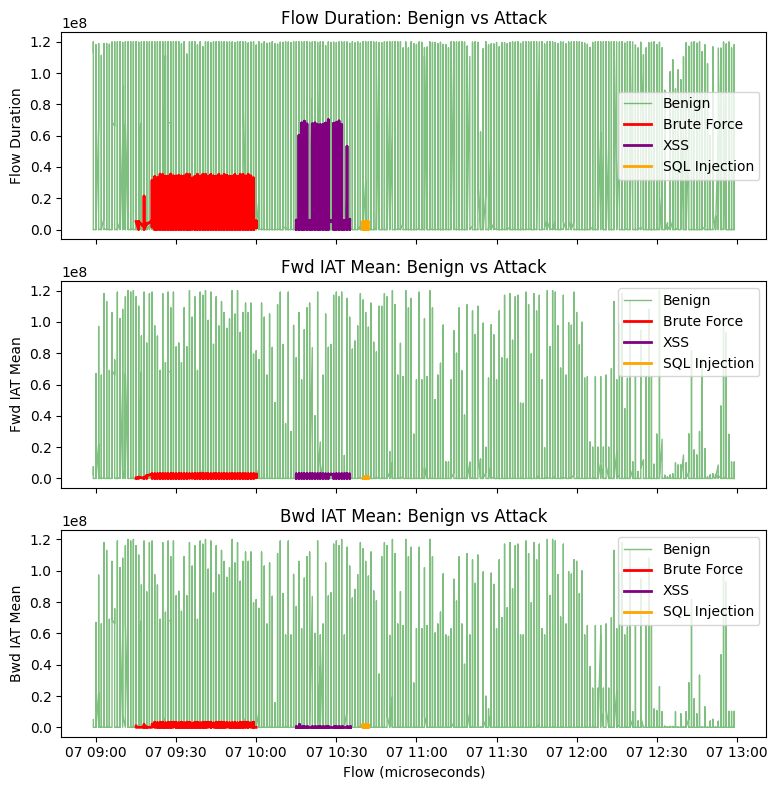

In [2]:
# Plotting Raw Data
benigns = df[df['Label'] == 0]
attacks = df[df['Label'] != 0]
brutes = df[df['Label'] == 11]
xss = df[df['Label'] == 12]
sqli = df[df['Label'] == 13]

features = ['Flow Duration', 'Fwd IAT Mean', 'Bwd IAT Mean']
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(benigns.index, benigns[col], color='green', linewidth=1, alpha=0.5, label='Benign')
    axs[i].plot(brutes.index, brutes[col], color='red', linewidth=2, label='Brute Force')
    axs[i].plot(xss.index, xss[col], color='purple', linewidth=2, label='XSS')
    axs[i].plot(sqli.index, sqli[col], color='orange', linewidth=2, label='SQL Injection')
    axs[i].set_title(f'{col}: Benign vs Attack')
    axs[i].set_ylabel(col)
    axs[i].legend()
plt.xlabel('Flow (microseconds)')
plt.tight_layout()
plt.show()


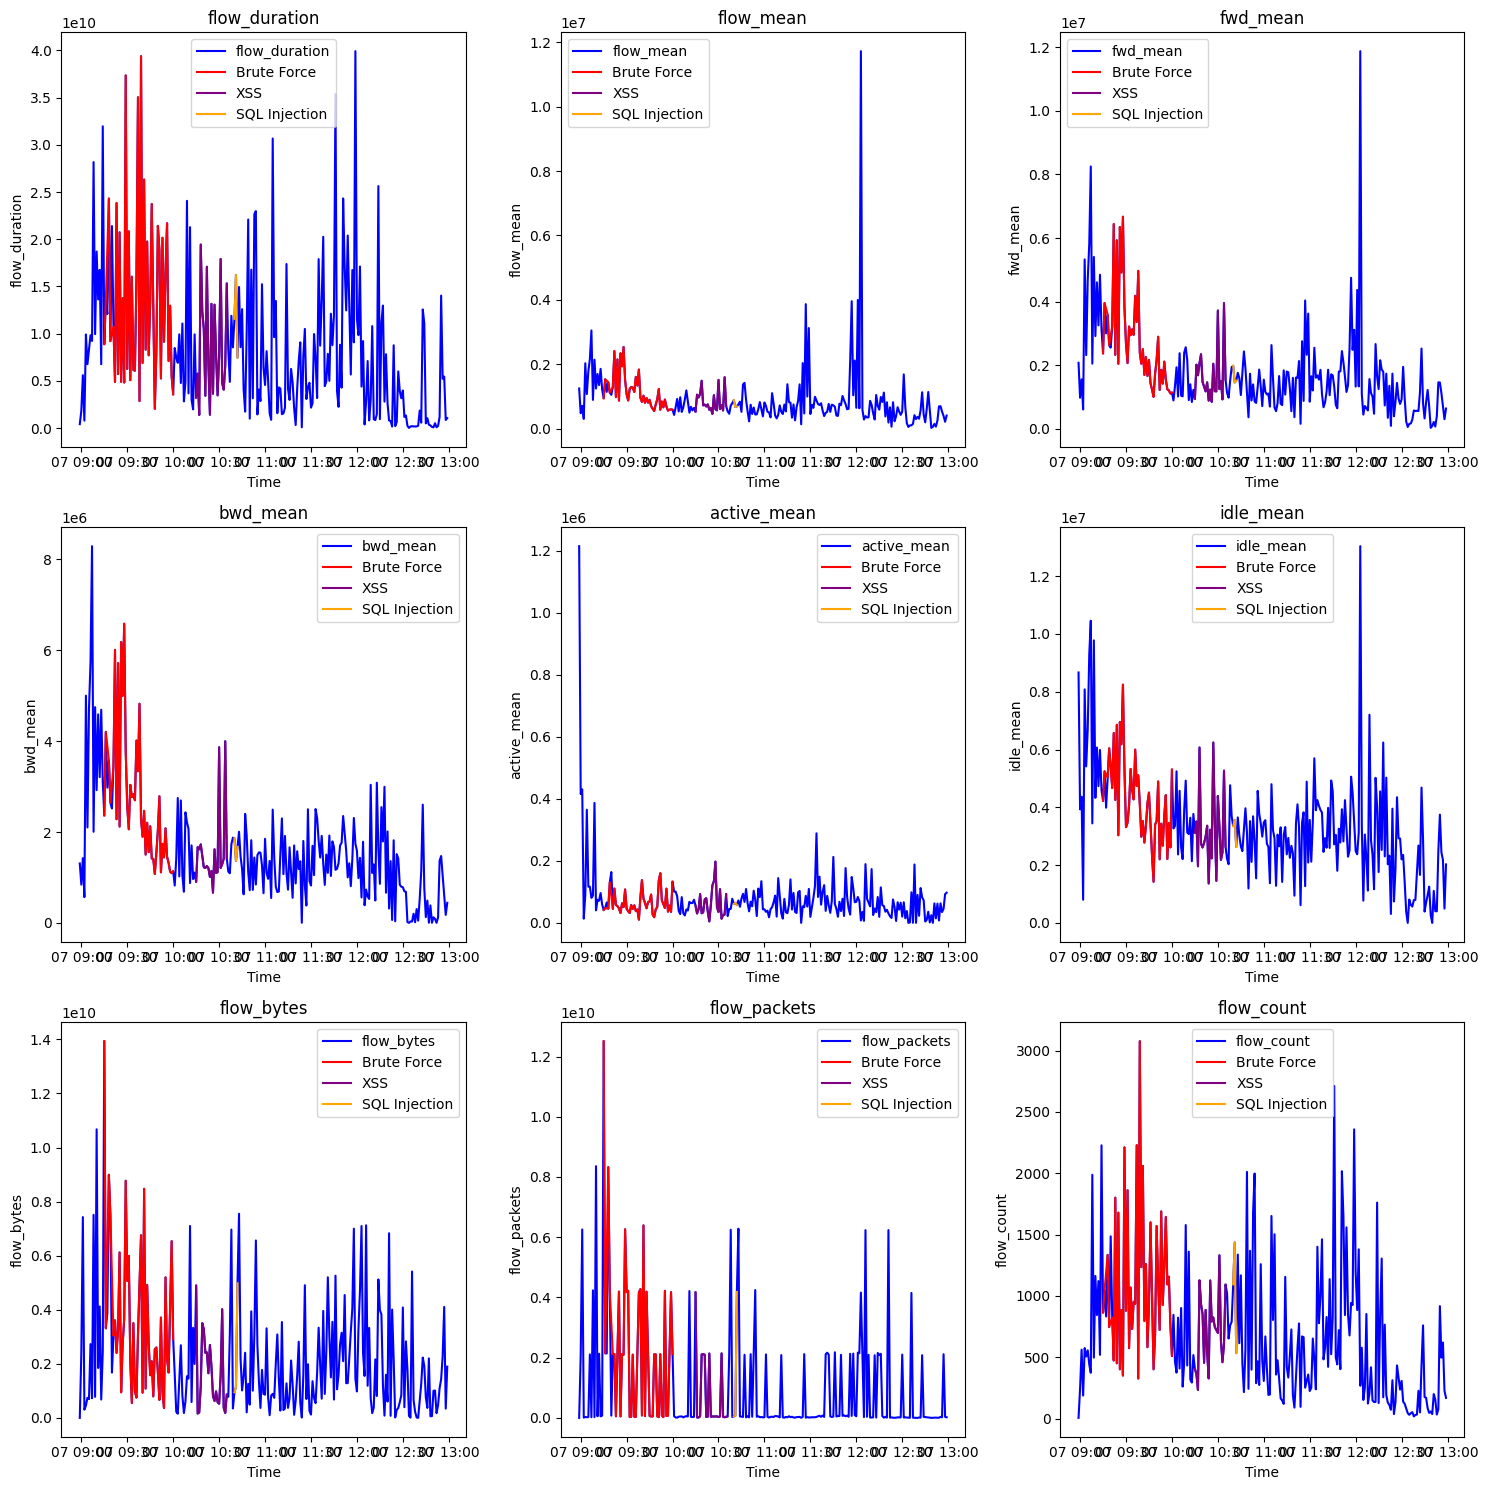

In [3]:
## Aggregation and resample by 60s
df['BruteForce'] = df['Label'].eq(11).astype(int)
df['XSS'] = df['Label'].eq(12).astype(int)
df['SQLi'] = df['Label'].eq(13).astype(int)
df['Benign'] = df['Label'].eq(0).astype(int)

def safe_mean(x):
    return np.mean(x.replace([np.inf, -np.inf], np.nan)) if not x.replace([np.inf, -np.inf], np.nan).isna().all() else np.nan
def safe_sum(x):
    return np.sum(x.replace([np.inf, -np.inf], np.nan)) if not x.replace([np.inf, -np.inf], np.nan).isna().all() else np.nan

aggregation_interval = '60s'
resampled_data = df.resample(aggregation_interval).agg(
    flow_count=('Source IP', 'size'),
    flow_duration=('Flow Duration', safe_sum),
    flow_bytes=('Flow Bytes/s', safe_sum),
    flow_packets=('Flow Packets/s', safe_sum),
    flow_mean=('Flow IAT Mean', safe_mean),
    fwd_mean=('Fwd IAT Mean', safe_mean),
    bwd_mean=('Bwd IAT Mean', safe_mean),
    active_mean=('Active Mean', safe_mean),
    idle_mean=('Idle Mean', safe_mean),
    label=('Label', 'max'),
    brute_force=('BruteForce', 'mean'),
    xss=('XSS', 'sum'),
    sqli=('SQLi', 'sum'),
    benign=('Benign', 'sum'),
)

brutes = resampled_data[resampled_data['brute_force'] > 0]
xss = resampled_data[resampled_data['xss'] > 0]
sqli = resampled_data[resampled_data['sqli'] > 0]
attributes = [
    'flow_duration', 'flow_mean', 'fwd_mean',
    'bwd_mean', 'active_mean', 'idle_mean',
    'flow_bytes', 'flow_packets', 'flow_count'
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout(pad=5.0)

for i, attr in enumerate(attributes):
    row, col = divmod(i, 3)
    axes[row, col].plot(resampled_data.index, resampled_data[attr], label=attr, color='blue')
    axes[row, col].plot(brutes.index, brutes[attr], color='red', label='Brute Force')
    axes[row, col].plot(xss.index, xss[attr], color='purple', label='XSS')
    axes[row, col].plot(sqli.index, sqli[attr], color='orange', label='SQL Injection')
    axes[row, col].set_title(attr)
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel(attr)
    axes[row, col].legend()

for i in range(len(attributes), 9):
    row, col = divmod(i, 3)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (241, 14)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()



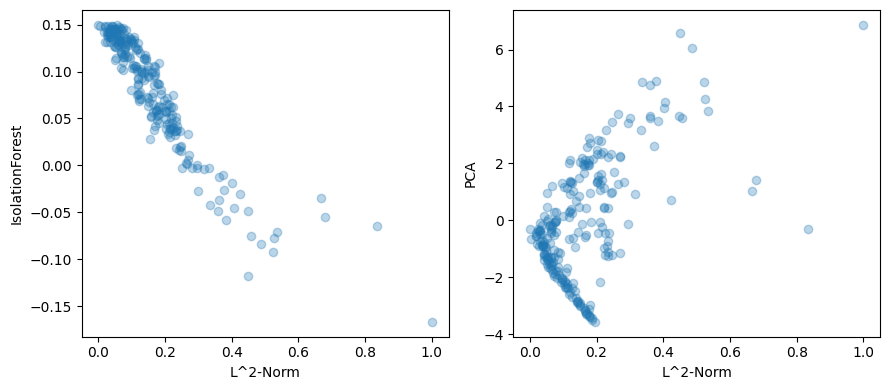

In [4]:
## Testing different Mapper lenses
scaler = StandardScaler()
X_scaled = scaler.fit_transform(resampled_data)

mapper = km.KeplerMapper(verbose=1)
lens1 = mapper.fit_transform(X_scaled, projection='l2norm')

projector = ensemble.IsolationForest(random_state=42)
projector.fit(X_scaled)
lens2 = projector.decision_function(X_scaled)

pca = PCA(n_components=1)
lens3 = pca.fit_transform(X_scaled)

fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].scatter(lens1,lens2,alpha=0.3)
axs[0].set_xlabel('L^2-Norm')
axs[0].set_ylabel('IsolationForest')
axs[1].scatter(lens1,lens3,alpha=0.3)
axs[1].set_xlabel('L^2-Norm')
axs[1].set_ylabel('PCA')
plt.tight_layout()
plt.show()

In [5]:
## Mapper algorithm
lens = np.c_[lens1, lens2]
cover = Cover(n_cubes=20, perc_overlap=0.20)
clusterer = DBSCAN(eps=5, min_samples=5)

G = mapper.map(
    lens,
    X_scaled,
    cover=cover,
    clusterer=clusterer,
)

_ = mapper.visualize(
    G,
    custom_tooltips=resampled_data['label'].values,
    color_values=resampled_data['label'].values,
    color_function_name="Label",
    path_html="mapper_cicids2017_agg.html",
    X=X_scaled,
    lens=lens,
)

from IPython.display import display, HTML, Image
display(HTML("mapper_cicids2017_agg.html"))


Mapping on data shaped (241, 14) using lens shaped (241, 2)

Creating 400 hypercubes.

Created 31 edges and 18 nodes in 0:00:00.152956.
Wrote visualization to: mapper_cicids2017_agg.html


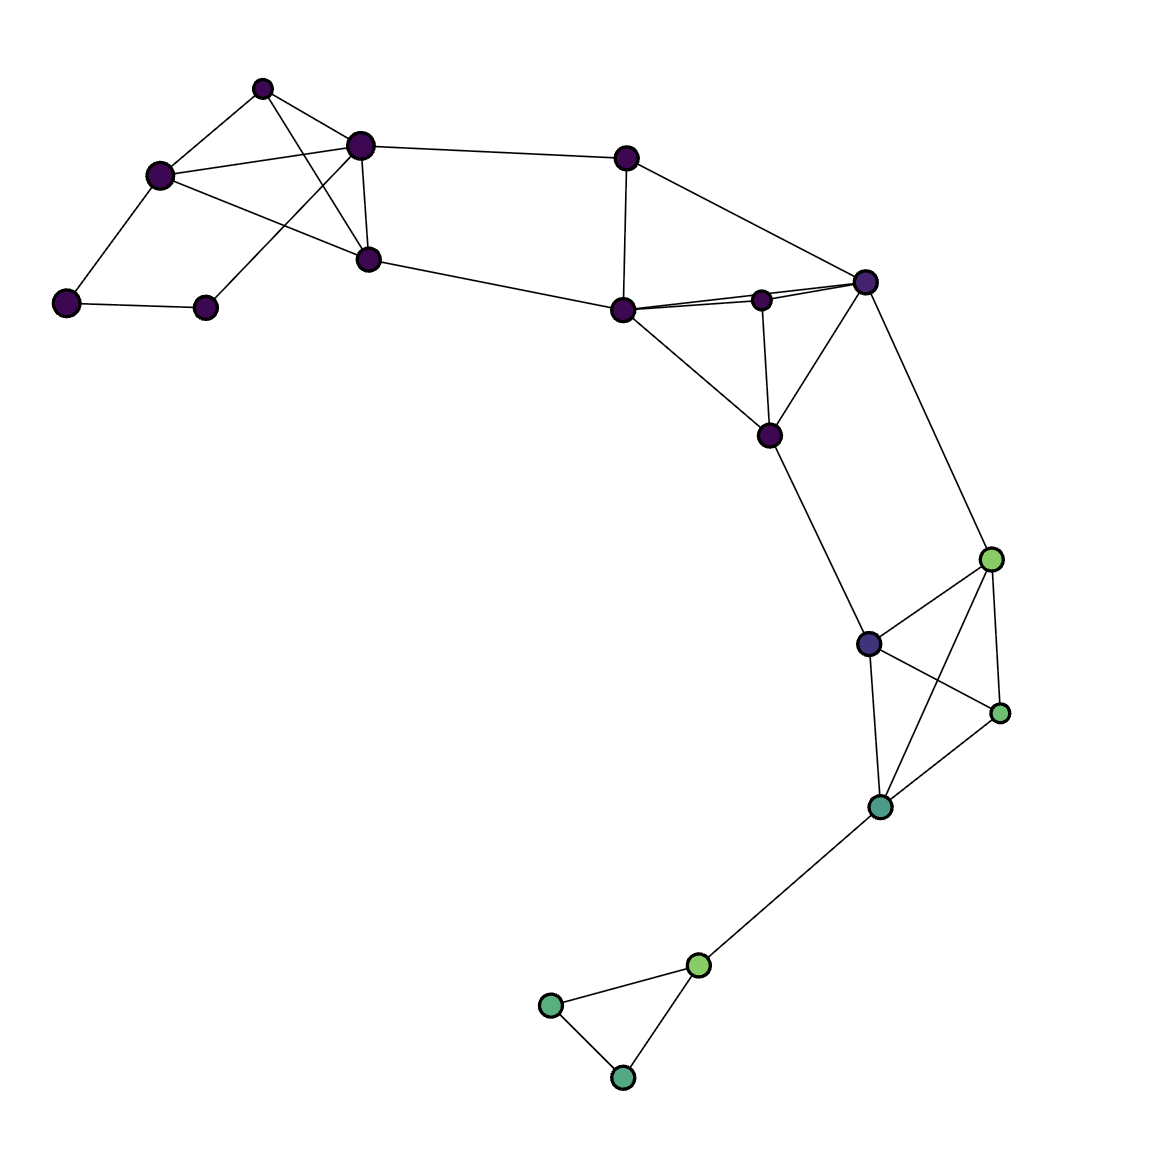

In [6]:
display(Image("mapper_cicids2017_agg.png"))

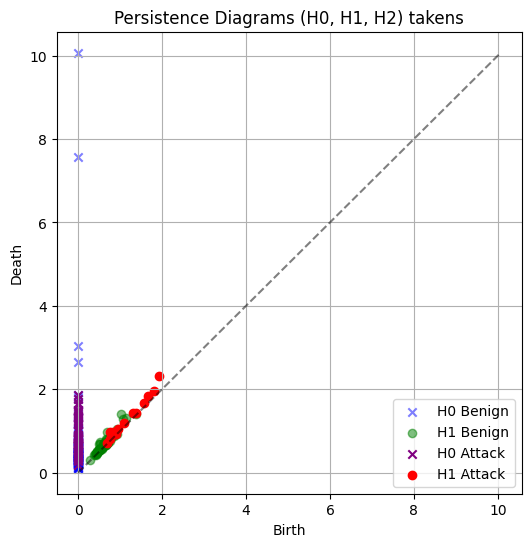

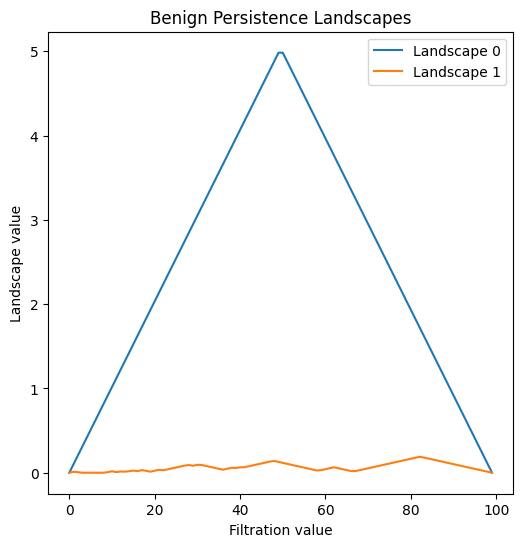

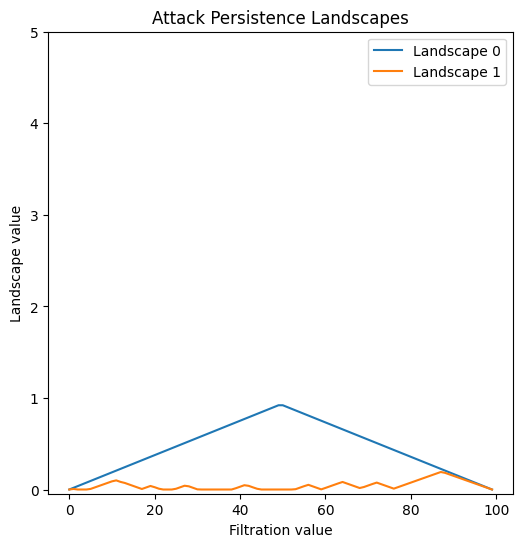

In [7]:
# Multi dimensional Takens with separate benigns and attacks
features = ['flow_duration', 'flow_mean', 'fwd_mean', 'bwd_mean', 'active_mean', 'idle_mean']
benigns = resampled_data[resampled_data['label'] == 0][features]
attacks = resampled_data[resampled_data['label'] != 0][features]

scaler = StandardScaler()
benigns_scaled = scaler.fit_transform(benigns)
benigns_scaled = pd.DataFrame(benigns_scaled, index=benigns.index, columns=features)
attacks_scaled = scaler.fit_transform(attacks)
attacks_scaled = pd.DataFrame(attacks_scaled, index=attacks.index, columns=features)

dim=benigns_scaled.columns.size
te = TakensEmbedding(time_delay=1, dimension=dim)
embedding_benigns = te.fit_transform(benigns_scaled)
embedding_benigns = embedding_benigns.reshape(benigns_scaled.index.size, dim)
embedding_attacks = te.fit_transform(attacks_scaled)
embedding_attacks = embedding_attacks.reshape(attacks_scaled.index.size, dim)

benigns_reshaped = embedding_benigns[None, :, :]
attacks_reshaped = embedding_attacks[None, :, :]

ph = VietorisRipsPersistence(homology_dimensions=[0, 1])
diagrams_benigns = ph.fit_transform(benigns_reshaped)
diagrams_attacks = ph.fit_transform(attacks_reshaped)

colors_benigns = {0: 'blue', 1: 'green', 2: 'darkgreen'}
colors_attacks = {0: 'purple', 1: 'red', 2: 'darkred'}
markers = {0: 'x', 1: 'o', 2: '^'}
labels = {0: 'H0', 1: 'H1', 2: 'H2'}
max_death = 6

fig = plt.subplots(figsize=(6, 6))
for dim in [0,1]:
    dgm = diagrams_benigns[0][diagrams_benigns[0][:, 2] == dim]
    if len(dgm) > 0:
        plt.scatter(dgm[:, 0], dgm[:, 1], c=colors_benigns[dim], marker=markers[dim],
                    label=f'{labels[dim]} Benign', alpha=0.5)
        max_death = max(max_death, max(dgm[:, 1]))
for dim in [0,1]:
    dgm = diagrams_attacks[0][diagrams_attacks[0][:, 2] == dim]
    if len(dgm) > 0:
        plt.scatter(dgm[:, 0], dgm[:, 1], c=colors_attacks[dim], marker=markers[dim],
                    label=f'{labels[dim]} Attack', alpha=1)
        max_death = max(max_death, max(dgm[:, 1]))
plt.plot([0, max_death], [0, max_death], 'k--', alpha=0.5)
plt.xlabel('Birth')
plt.ylabel('Death')
plt.title('Persistence Diagrams (H0, H1, H2) takens')
plt.legend()
plt.grid(True)
plt.show()

pl = PersistenceLandscape()
landscapes_benigns = pl.fit_transform(diagrams_benigns)
fig = plt.figure(figsize=(6, 6))
for i in range(landscapes_benigns.shape[1]):
    plt.plot(landscapes_benigns[0, i], label=f'Landscape {i}')
plt.xlabel('Filtration value')
plt.ylabel('Landscape value')
plt.legend()
plt.yticks(np.arange(0, 6, step=1))
plt.title('Benign Persistence Landscapes')
plt.show()

landscapes_attacks = pl.fit_transform(diagrams_attacks)
fig = plt.figure(figsize=(6, 6))
for i in range(landscapes_attacks.shape[1]):
    plt.plot(landscapes_attacks[0, i], label=f'Landscape {i}')
plt.xlabel('Filtration value')
plt.ylabel('Landscape value')
plt.legend()
plt.yticks(np.arange(0, 6, step=1))
plt.title('Attack Persistence Landscapes')
plt.show()


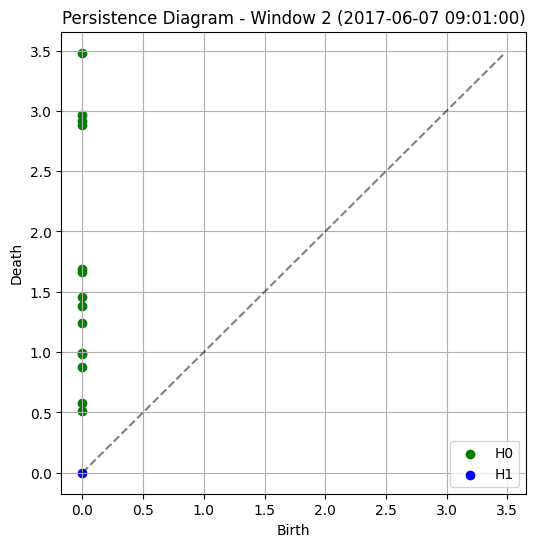

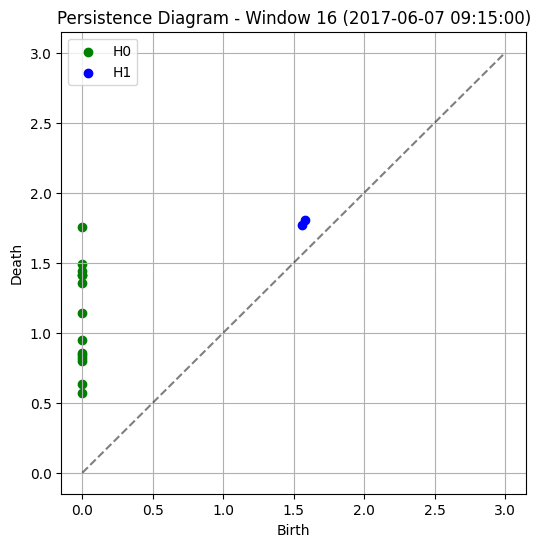

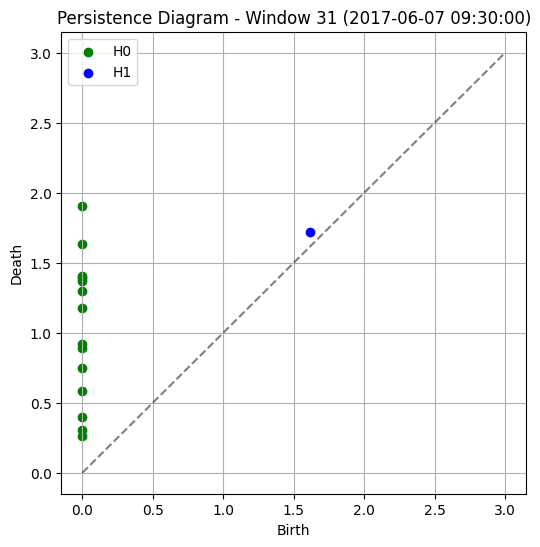

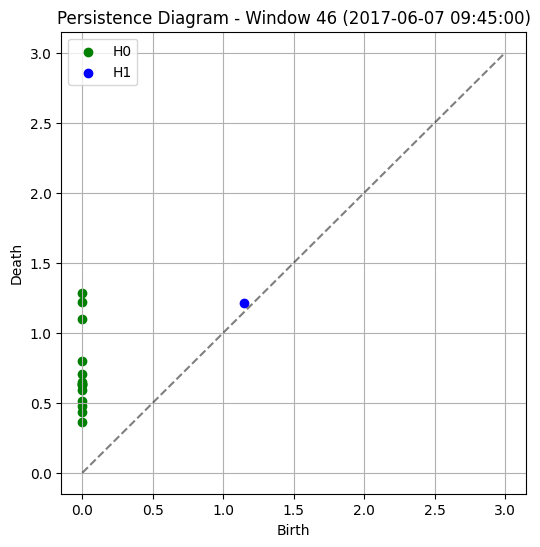

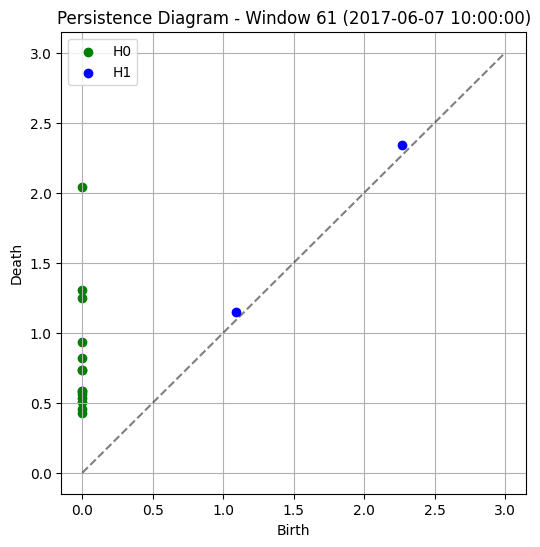

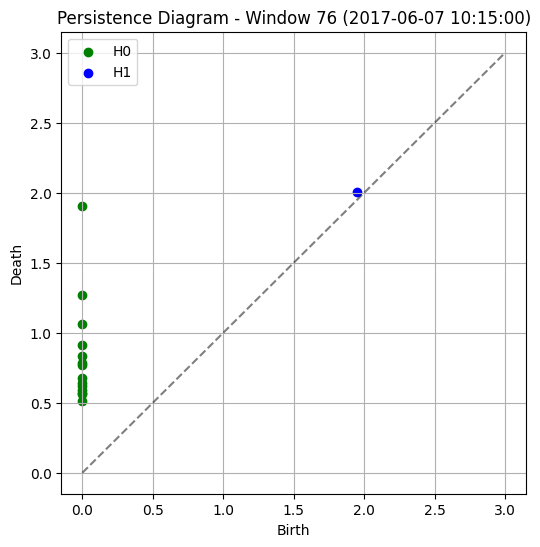

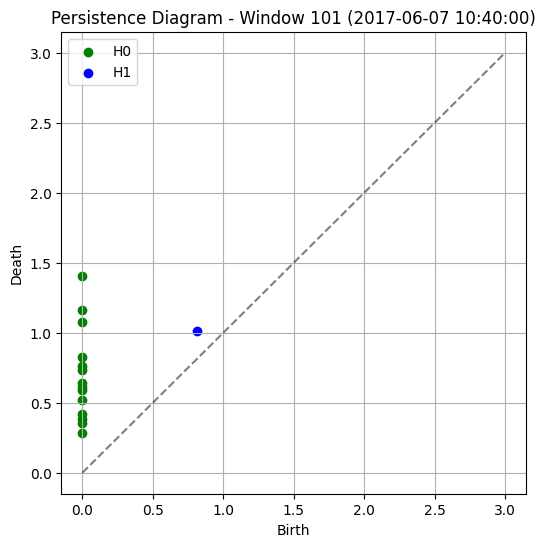

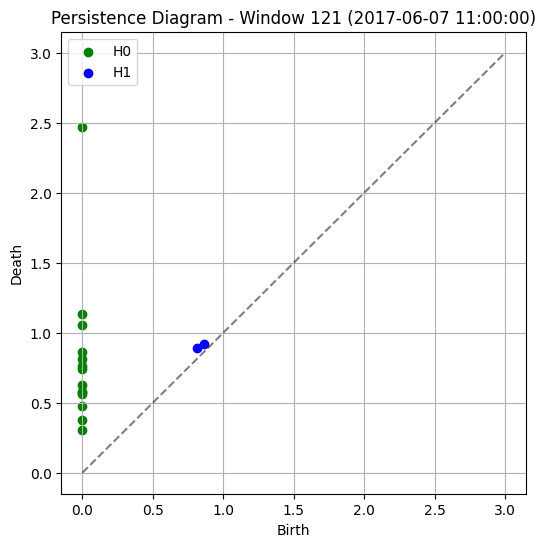

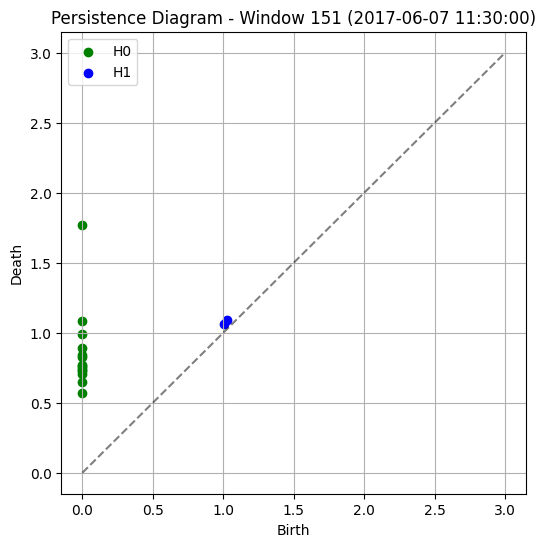

In [ ]:
# sliding window approach, combining benigns and attacks
featured_df = resampled_data[features]
df_scaled = scaler.fit_transform(featured_df)
df_scaled = pd.DataFrame(df_scaled, index=featured_df.index, columns=features)

colors = {0: 'green', 1: 'blue', 2: 'red'}
markers = {0: 'x', 1: 'o', 2: 's'}
labels = {0: 'H0', 1: 'H1', 2: 'H2'}

window_size = pd.Timedelta(seconds=900) # 15 minutes
step_size = pd.Timedelta(seconds=60)
window_samples = int(window_size / pd.Timedelta(aggregation_interval))
step_samples = int(step_size / pd.Timedelta(aggregation_interval))

for window_idx in range(0, len(df_scaled) - window_samples + 1, step_samples):
    window_data = df_scaled.iloc[window_idx:window_idx + window_samples]
    if len(window_data) < window_samples:
        continue

    # select a few frames
    if window_data.index[0] not in [pd.Timestamp('2017-06-07 09:01:00'), pd.Timestamp('2017-06-07 09:15:00'), pd.Timestamp('2017-06-07 09:30:00'), pd.Timestamp('2017-06-07 09:45:00'), pd.Timestamp('2017-06-07 10:00:00'), pd.Timestamp('2017-06-07 10:15:00'), pd.Timestamp('2017-06-07 10:40:00'), pd.Timestamp('2017-06-07 11:00:00'), pd.Timestamp('2017-06-07 11:30:00'),]:
        continue

    try:
        embedding = te.fit_transform(window_data.values)
        embedding = embedding.reshape(window_data.index.size, window_data.columns.size)
        embedding_reshaped = embedding[None, :, :]
    except ValueError as e:
        print(f"Skipping window {window_idx} due to embedding error: {e}")
        continue

    try:
        diagrams = ph.fit_transform(embedding_reshaped)
    except ValueError as e:
        print(f"Skipping window {window_idx} due to persistence error: {e}")
        continue

    fig, ax = plt.subplots(figsize=(6, 6))
    max_death = 3
    for dim in [0, 1]:
        dgm = diagrams[0][diagrams[0][:, 2] == dim]
        if len(dgm) > 0:
            ax.scatter(dgm[:, 0], dgm[:, 1], c=colors[dim], label=f'{labels[dim]}', alpha=1)
            max_death = max(max_death, max(dgm[:, 1]))

    ax.plot([0, max_death], [0, max_death], 'k--', alpha=0.5)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title(f'Persistence Diagram - Window {window_idx} ({window_data.index[0]})')
    ax.legend()
    ax.grid(True)
    plt.show()

In [9]:
## Attacks happen from 
# 09:15 - 10:00, 
# 10:15 - 10:35, 
# 10:40 - 10:42,